In [21]:
import jax
import jax.numpy as jnp
from jax import jit, vmap

import matplotlib.pyplot as plt


In [22]:
def correlate_weiner_process(X, sigma, dt):
    L = jnp.linalg.cholesky(sigma).T
    return jnp.sqrt(dt) * L @ X

def update_process(xt, dt, alpha, mu, sigma, dZt):
    dxt_drift = alpha * (mu - xt) * dt
    dxt_stochastic_variation = sigma * jnp.sqrt(xt) * dZt

    return xt + dxt_drift + dxt_stochastic_variation

def generate_process(x0, alpha, mu, sigma, dZ):
    x = jnp.zeros(len(dZ))
    x.at[0].set(x0)

    for i in range(1, len(dZ)):

        x = x.at[i].set(update_process(x[i-1], 1, alpha, mu, sigma, dZ[i]))
    
    return x

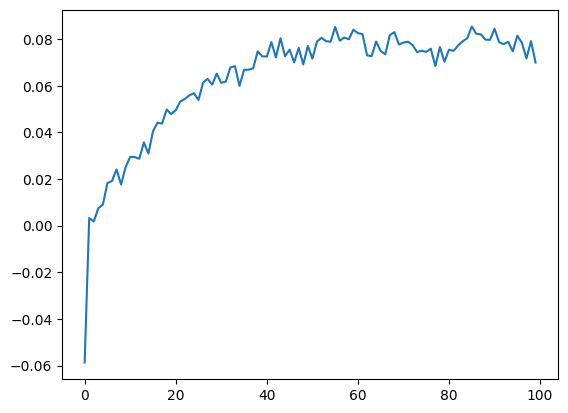

In [23]:
n_years = 100
dt = 1 / 12

n_factors = 2
key = jax.random.PRNGKey(0)
X = jax.random.normal(key=key, shape=(n_factors, n_years))

rho = - 0.739
weiner_sigma = jnp.array([[1, rho], [rho, 1]])
weiner_L = jnp.linalg.cholesky(weiner_sigma).T
dZ = correlate_weiner_process(X, weiner_L, dt)

# Initial values
x_10 = 0.0228
x_20 = 0.0809
# Parameters
a_1 = 1.0682
m_1 = 0.0546
s_1 = 0.0412
a_2 = 0.0469
m_2 = 0.0778
s_2 = 0.0287


x_1 = generate_process(x_10, a_1, m_1, s_1, dZ[0])
x_2 = generate_process(x_20, a_2, m_2, s_2, dZ[1])

phi = 0.045 - (x_10 + x_20)
n = phi + x_1 + x_2

plt.plot(n)